In [15]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_community.callbacks import get_openai_callback
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
import requests
import json
import pandas
import csv
import timeit
import numpy as np

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

## Context Creation

In [2]:
# Create a string containing context from ClinicalTrials.gov based on the trials we care about. 

def get_trial_criteria(trials):
    trialContext = ''
    for trial in trials:
        url = 'https://clinicaltrials.gov/api/v2/studies/{t}?fields=EligibilityModule'.format(t=trial)
        response = requests.get(url)
        eligibilityCriteria = json.loads(response.text)
        strippedEligCrit = eligibilityCriteria['protocolSection']['eligibilityModule']['eligibilityCriteria']
        trialContext += '============\n\n' + 'Eligibility criteria for Trial ' + trial + '. \n\n' + strippedEligCrit + '\n\n'
    return trialContext

In [3]:
# Determine a patient's eligibility for all the trials provided a single time.

def run_eligibility_chain(template, model_to_use, trialContext, patient):
    prompt = ChatPromptTemplate.from_template(template)
    parser = StrOutputParser()
    chain = prompt | model_to_use | parser
    return chain.invoke({"context":trialContext, "scenario":patient})

In [4]:
# Iterate through chain n times for a single patient and collect all responses.

def iterate_chain(template, trialContext, patient, model, n=5):
    responses = ''
    responses+= 'There are ' + str(n) + ' experts\' responses.'
    for i in range(n):
        response = run_eligibility_chain(template, model, trialContext, patient)
#         response = "RESPONSE"
        responses += ('\n\nExpert response:\n\n' + response +  '\n\n ============= \n\n')
#         print(response)
    
    return responses

In [5]:
# Run the ensembling model to create a consensus response.

def run_composite_prompt(composite_prompt, model_to_use, responses):
    prompt = ChatPromptTemplate.from_template(composite_prompt)
    parser = StrOutputParser()
    chain = prompt | model_to_use | parser
    
    return chain.invoke({"responses":responses})

In [6]:
# Run the screening process on one patient.

def screen_patient(redcap_id, clinical_free_text, trials, model):
    trial_context = get_trial_criteria(trials)
    
    intro_template = open('./intro_template.txt').read()
    
    # Run eligibility chain, N times
    with get_openai_callback() as eligibility_cb:
        responses = iterate_chain(intro_template, trial_context, clinical_free_text, model)
        
    usage_df.loc[redcap_id, 'Eligibility Cost'] = eligibility_cb.total_cost
    usage_df.loc[redcap_id, 'Eligibility Total Tokens'] = eligibility_cb.total_tokens
    usage_df.loc[redcap_id, 'Eligibility Prompt Tokens'] = eligibility_cb.prompt_tokens
    usage_df.loc[redcap_id, 'Eligibility Completion Tokens'] = eligibility_cb.completion_tokens

    print("\n Eligibility Done \n")

    composite_template = open('./composite_template.txt').read()
    
    # Ensemble N responses into a consensus
    with get_openai_callback() as ensembling_cb:
        ensembled_responses = run_composite_prompt(composite_template, model, responses) 
    usage_df.loc[redcap_id, 'Ensembling Cost'] = ensembling_cb.total_cost
    usage_df.loc[redcap_id, 'Ensembling Total Tokens'] = ensembling_cb.total_tokens
    usage_df.loc[redcap_id, 'Ensembling Prompt Tokens'] = ensembling_cb.prompt_tokens
    usage_df.loc[redcap_id, 'Ensembling Completion Tokens'] = ensembling_cb.completion_tokens
                
    print("\n Ensembling Done \n")
    
    return ensembled_responses

In [7]:
# Given the consensus statement, create a JSON with binary values for each of the trial criteria. 

def create_json(model_to_use, consensus):
#     print(consensus) 
    
    json_template = open('./json_template.txt').read()

    prompt = ChatPromptTemplate.from_template(json_template)
    parser = StrOutputParser() # TODO: check if this is the best parser and prompt template combo for this use case
    chain = prompt | model_to_use | parser
    
    return chain.invoke({"consensus":consensus})

In [8]:
import csv
import json
import re

KEY_MAP = {
    'Age': {
        'col': 'Age',
    },
    'Diagnosis 0': {
        'col': 'Diagnosis',
        'true': 'Pancreatic ductal adenocarcinoma',
    },
    'Diagnosis 1': {
        'col': 'Diagnosis',
        'true': 'Pancreatic acinar cell carcinoma',
    },
    'Diagnosis 2': {
        'col': 'Diagnosis',
        'true': 'Pancreatic islet cell carcinoma',
    },
    'Diagnosis 3': {
        'col': 'Diagnosis',
        'true': 'Pancreatic neuroendocrine tumor',
    },
    'BRCA Status': {
        'col': 'BRCA Status',
    },
    'Resectability 0': {
        'col': 'Resectability and Metastasis',
        'true': 'Resectable',
    },
    'Resectability 1': {
        'col': 'Resectability and Metastasis',
        'true': 'Borderline resectable',
    },
    'Resectability 2': {
        'col': 'Resectability and Metastasis',
        'true': 'Locally advanced',
    },
    'Resectability 3': {
        'col': 'Resectability and Metastasis',
        'true': 'Metastatic',
    },
    'Resectability 4': {
        'col': 'Resectability and Metastasis',
        'true': 'Metastatic with lesions in CNS',
    },
    'Prior therapy 0': {
        'col': 'Prior therapy',
        'true': 'Any prior adjuvant, neoadjuvant, or induction treatment for pancreatic cancer',
    },
    'Prior therapy 1': {
        'col': 'Prior therapy',
        'true': 'Chemotherapy',
    },
    'Prior therapy 2': {
        'col': 'Prior therapy',
        'true': 'Radiotherapy',
    },
    'Prior therapy 3': {
        'col': 'Prior therapy',
        'true': 'Chemo/radiation within 4 weeks',
    },
    'Prior therapy 4': {
        'col': 'Prior therapy',
        'true': 'T-cell costimulation or immune checkpoint blockade therapies',
    },
    'Prior therapy 5': {
        'col': 'Prior therapy',
        'true': 'Hormonal therapy',
    },
    'Prior therapy 6': {
        'col': 'Prior therapy',
        'true': 'Surgical resection',
    },
    'Notable outcomes 0': {
        'col': 'Notable outcomes of prior therapy',
        'true': 'Disease progression on 5-FU for metastatic/unresectable PDAC',
    },
    'Notable outcomes 1': {
        'col': 'Notable outcomes of prior therapy',
        'true': 'Macroscopically complete (R0 or R1 resection) 6-12 weeks prior',
    },
    'Notable outcomes 2': {
        'col': 'Notable outcomes of prior therapy',
        'true': 'Clinically significant adverse events excluding alopecia and Grade <=2 peripheral neuropathy',
    },
    'ECOG greater than 1': {
        'col': 'ECOG performance status',
        'true': '0,1',
    },
    'ECOG greater than 2': {
        'col': 'ECOG performance status',
        'true': '0,1,2',
    },
    'PMH_0': {
        'col': 'Active past medical history',
        'true': 'Uncontrolled intercurrent illness',
    },
    'PMH_01': {
        'col': 'Active past medical history',
        'true': 'Uncontrolled HTN',
    },
    'PMH_02': {
        'col': 'Active past medical history',
        'true': 'Vasomotor instability',
    },
    'PMH_03': {
        'col': 'Active past medical history',
        'true': 'Seizure disorder',
    },
    'PMH_04': {
        'col': 'Active past medical history',
        'true': 'Hx retinopathy or high risk of retianl detachment',
    },
    'PMH_05': {
        'col': 'Active past medical history',
        'true': 'Uncontrolled tumor-related pain with actively changing narcotic regimen',
    },
    'PMH_06': {
        'col': 'Active past medical history',
        'true': 'History of leptomeningeal disease',
    },
    'PMH_07': {
        'col': 'Active past medical history',
        'true': 'Preexisting Grade >/=2 neuropathy',
    },
    'PMH_08': {
        'col': 'Active past medical history',
        'true': 'Severe obstructive pulmonary disease or interstitial lung disease, pulm fibrosis, pulmonary hypersensitivity reaction, active tuberculosis',
    },
    'PMH_09': {
        'col': 'Active past medical history',
        'true': 'Uncontrolled pleural effusion, pericardial effusion, or ascites requiring recurrent drainage.',
    },
    'PMH_10': {
        'col': 'Active past medical history',
        'true': 'GI condition which could impair absorption or ability to ingest study drug (i.e. evidence of GI obstruction)',
    },
    'PMH_11': {
        'col': 'Active past medical history',
        'true': 'Peptic ulcer disease',
    },
    'PMH_12': {
        'col': 'Active past medical history',
        'true': 'Inflammatory dz of colon and rectum, severe uncontrolled diarrhea, Celiac disease',
    },
    'PMH_13': {
        'col': 'Active past medical history',
        'true': 'History of rhabdomyolysis or elevated creatine phosphokinase (CPK)',
    },
    'PMH_14': {
        'col': 'Active past medical history',
        'true': 'Clinically significant liver disease including alc hepatitis, cirrhosis, FLD, inherited liver dz',
    },
    'PMH_15': {
        'col': 'Active past medical history',
        'true': "Gilbert's disease",
    },
    'PMH_16': {
        'col': 'Active past medical history',
        'true': 'Uncontrolled hypercalcemia (on labs or symptomatic, requiring bisphosphonate therapy for hyperCa)',
    },
    'PMH_17': {
        'col': 'Active past medical history',
        'true': 'Uncontrolled hyperthyroidism (clinical hyperthyroidism uncontrolled by oral medication)',
    },
    'PMH_18': {
        'col': 'Active past medical history',
        'true': 'History of allogeneic organ or stem cell transplant',
    },
    'PMH_19': {
        'col': 'Active past medical history',
        'true': 'DVT, portal vein occlusion, PE, or other thromboembolic event during screening',
    },
    'PMH_20': {
        'col': 'Active past medical history',
        'true': 'Grade ≥ 3 hemorrhage or bleeding event within 28 days prior to initiation of study treatment',
    },
    'PMH_21': {
        'col': 'Active past medical history',
        'true': 'Active autoimmune disease, uncontrolled psoriasis, porphyria, proximal myopathy or neuropathy (excluding hypothyroidism on thyroid replacement, controlled T1DM, well-controlled skin conditions)',
    },
    'PMH_22': {
        'col': 'Active past medical history',
        'true': 'Active infections requiring systemic therapy',
    },
    'Other Malignancy': {
        'col': 'Other Malignancy',
    },
    'Cardiac history 0': {
        'col': 'Cardiac History',
        'true': 'Active/symptomatic CAD, MI, stroke, or PCI within 2 years',
    },
    'Cardiac history 1': {
        'col': 'Cardiac History',
        'true': 'Life-threatening arrhythmia',
    },
    'Cardiac history 2': {
        'col': 'Cardiac History',
        'true': 'EF <40% within last 3 months',
    },
    'Cardiac history 3': {
        'col': 'Cardiac History',
        'true': 'NYHA Class III or IV CHF within 3 months of first treatment',
    },
    'PSxH 0': {
        'col': 'Past Surgical History',
        'true': 'GI/colon resection within 12 months',
    },
    'PSxH 1': {
        'col': 'Past Surgical History',
        'true': 'Urinary bladder surgery within 12 months',
    },
    'PSxH 2': {
        'col': 'Past Surgical History',
        'true': 'Any history of splenectomy / functional asplenia',
    },
    'PSxH 3': {
        'col': 'Past Surgical History',
        'true': 'Major surgery requiring general anesthesia within 1 month',
    },
    'Psych Hx 0': {
        'col': 'Psychiatric History',
    },
    'Psych Hx 1': {
        'col': 'Depression History',
    },
    'Medications 0': {
        'col': 'Medication History',
        'true': 'Inhibitors or inducers of CYP3A4 https://www.uptodate.com/contents/image?imageKey=DRUG/76992;',
    },
    'Medications 1': {
        'col': 'Medication History',
        'true': 'Acetylcholinesterase inhibitor',
    },
    'Medications 2': {
        'col': 'Medication History',
        'true': 'Metformin',
    },
    'Medications 3': {
        'col': 'Medication History',
        'true': 'Hydroxychloroquine',
    },
    'Medications 4': {
        'col': 'Medication History',
        'true': 'Actively adjusting anticoagulation',
    },
    'Medications 5': {
        'col': 'Medication History',
        'true': 'Brivudine or sorivudine',
    },
    'Medications 6': {
        'col': 'Medication History',
        'true': 'UGT1A1 inhibitors https://go.drugbank.com/categories/DBCAT003925 or inducers https://go.drugbank.com/categories/DBCAT002664 ',
    },
    'Medications 7': {
        'col': 'Medication History',
        'true': 'Systemic immunosuppresion (including, but not limited to, corticosteroids, cyclophosphamide, azathioprine, methotrexate, thalidomide, calcineurin inhibitors, and anti-tumor necrosis factor alpha agents',
    },
    'Medications 8': {
        'col': 'Medication History',
        'true': '> 10mg prednisone or equivalent daily',
    },
    'Investigational Medications': {
        'col': 'Other investigational medications',
    },
    'Allergies 0': {
        'col': 'Allergies',
        'true': 'Compounds of similar chemical or biologic composition to CA-4948 ',
    },
    'Allergies 1': {
        'col': 'Allergies',
        'true': 'Gemcitabine',
    },
    'Allergies 2': {
        'col': 'Allergies',
        'true': 'Nab-paclitaxel',
    },
    'Allergies 3': {
        'col': 'Allergies',
        'true': 'Oxaliplatin, irinotecan, leucovorin, fluorouracil, pegfilgrastim, or any excipients.',
    },
    'Allergies 4': {
        'col': 'Allergies',
        'true': 'Chimeric or humanized antibodies or fusion proteins',
    },
    'Allergies 5': {
        'col': 'Allergies',
        'true': 'Chinese hamster ovary cell products or recombinant human antibodies',
    },
    'Vitals': {
        'col': 'Vitals',
    },
    'Hemoglobin': {
        'col': 'Abnormal Labs',
        'true': 'Hemoglobin <9.0 without transfusion within 1 week',
    },
    'ANC': {
        'col': 'Abnormal Labs',
        'true': 'ANC < 1.5 x 10^9',
    },
    'Lymphocyte count': {
        'col': 'Abnormal Labs',
        'true': 'Lymphocyte count < 0.5 x 10^9/L (500/uL)',
    },
    'Platelets': {
        'col': 'Abnormal Labs',
        'true': 'Platelets < 100 x 10^9/L',
    },
    'Tbili': {
        'col': 'Abnormal Labs',
        'true': 'Total bili > 1.5x ULN (or > 3x ULN if Gilbert dz)',
    },
    'AST/ALT': {
        'col': 'Abnormal Labs',
        'true': 'AST/ALT > 3x ULN',
    },
    'Coags': {
        'col': 'Abnormal Labs',
        'true': 'Coags > 2.5x ULN',
    },
    'Albumin': {
        'col': 'Abnormal Labs',
        'true': 'Albumin < 3.0 g/dL',
    },
    'GFR': {
        'col': 'Abnormal Labs',
        'true': 'GFR < 60 mL/min',
    },
    'CPK': {
        'col': 'Abnormal Labs',
        'true': 'CPK > 2.5x ULN',
    },
    'HIV Status': {
        'col': 'HIV Status',
    },
    'Hep B Status': {
        'col': 'Hepatitis B Status',
    },
    'Hep C Status': {
        'col': 'Hepatitis C Status',
    },
    'Breastfeeding': {
        'col': 'Breastfeeding',
    },
    'Imaging': {
        'col': 'Imaging',
    },
    'Unsafe Bx': {
        'col': 'Unsafe for biopsy',
    },
    'Alternative Medicine': {
        'col': 'Alternative medicine',
    },
    'Life expectancy': {
        'col': 'Life expectancy',
    },
    'Radiation contraindications': {
        'col': 'Radiation Contraindications',
    },
    'Dihydropyrimidine dehydrogenase deficiency': {
        'col': 'Dihidropyrimidine dehydrogenase deficiency',
    },
    'Live attenuated vaccines': {
        'col': 'Live attenuated vaccines',
    },
    'DVT Testing': {
        'col': 'DVT Testing',
    },
    'Tumor Staging': {
        'col': 'Tumor Staging',
    },
    'R2578 (Morpheus)': {
        'col': 'R2578 Preliminary Eligibility (Morpheus)',
    },
    'S7260 (ARC-8)': {
        'col': 'S7260 Preliminary Eligibility (ARC-8)',
    },
    'S9513 (Chemo4METPANC)': {
        'col': 'S9513 Preliminary Eligibility (Chemo4METPANC)',
    },
    'T5285 (Bethanechol)': {
        'col': 'T5285 Preliminary Eligibility (Bethanechol)',
    },
    'T5973 (TIGeR-PaC)': { 
        'col': 'T5973 Preliminary Eligibility (TIGeR-PaC)',
    },
    'U1236 (Panbela)': {
        'col': 'U1236 Preliminary Eligibility (Panbela)',
    },
    'U4206 (AIRPanc)': {
        'col': 'U4206 Preliminary Eligibility (AIRPanc)',
    },
    'U5427 (Vaccine)': {
        'col': 'U5427 Preliminary Eligibility (Vaccine)',
    },
    'U6715 (CA-4948)': {
        'col': 'U6715 Preliminary Eligibility (CA-4948)',
    },
}

def map(human_json, llm_json):
    """
    Identify false negatives/positives from the LLM output.
    """
    res = {}
    for llm_key, llm_val in llm_json.items():
        human_key = KEY_MAP[llm_key]['col']
        human_val = human_json[human_key]
#         print('! ', human_key)
#         print('! ', human_val)
#         print('! ', llm_val)
    
        target = KEY_MAP[llm_key].get('true')
        if llm_key == "ECOG greater than 1":
            if llm_val == False:
                if human_val in '0,1':
                    llm_val = human_val
            elif llm_val == True:
                if human_val not in '0,1':
                    llm_val = human_val
            else:
                if human_val == 'Unsure' and llm_val == None: 
                    llm_val = human_val
            res[llm_key] = 1 if llm_val == human_val else 0

        elif llm_key == "ECOG greater than 2":
            if llm_val == False:
                if human_val in '0,1,2':
                    llm_val = human_val
            elif llm_val == True:
                if human_val not in '0,1,2':
                    llm_val = human_val
            else:
                if human_val == 'Unsure' and llm_val == None: 
                    llm_val = human_val
            res[llm_key] = 1 if llm_val == human_val else 0
        elif target is not None:
            if target in human_val:
                res[llm_key] = 1 if llm_val else 0
            else:
                res[llm_key] = 1 if not llm_val else 0
        else:
            if llm_val == True:
                llm_val = 'TRUE'
            elif llm_val == False:
                llm_val = 'FALSE'
            else:
                llm_val = 'Unsure'
            res[llm_key] = 1 if llm_val == human_val else 0
    return res

In [9]:
def model_output_to_dict(string):
    return json.loads(string[8:-4])

def number_correct(answer):
    correct = 0
    incorrect = []
    for key, val in answer.items():
        if not val:
            incorrect.append(key)
        correct += val
    return str(correct)+'/'+str(len(answer)), incorrect


# Calculating Correctness  (Run to Grade)

In [149]:
import time

newpath = input('path: ')

def grade():
    # Grading loop 
#     model_outputs = pandas.read_csv('./' + newpath + '/model_outputs.csv')
    model_outputs = pandas.read_csv('./' + newpath + '/model_outputs_validated.csv')

    # Open the CSV for writing.
    with open('./' + newpath + '/graded_model_outputs.csv', 'w', newline='') as csvfile:
        fieldnames = ['Redcap ID', 'Screening Cost', 'Model Free Text Output', 'Model JSON Output', 'Human JSON', 'Graded Model JSON', 'Number Correct']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        # Loop through the patients in the dataframe.
        for i in range(len(model_outputs)):
            patient = model_outputs.iloc[i]
            redcap_id = patient['Redcap ID']
            print('=== grading redcap ID', redcap_id)
            
            # Get the answer key row based on the Redcap ID
            with open("answer_key_test.csv", newline="") as human_csv:
                human_csv = csv.reader(human_csv, delimiter=",", quotechar='"')
                human_csv = list(human_csv)

            # Make the row into a JSON    
            human_col_names = human_csv[0]
            for human_row in human_csv[1:]:
                if int(human_row[0]) != redcap_id:
                    continue
                human_json = {
                    col.strip('\n'): val.strip('\n')
                    for col, val
                    in zip(human_col_names, human_row)
                }

            llm_json = patient['Model JSON Output']
            print(llm_json)
            # Run grading function on the llm_json and human_json. 
            if llm_json[0] == '`':
                stripped_llm_json = llm_json[8:-4]
                print(stripped_llm_json)
                answer_json = map(human_json, json.loads(stripped_llm_json))
            else:
                answer_json = map(human_json, json.loads(llm_json))
            


            # Write the free text output, LLM JSON, and graded output to model_outputs.csv.
            writer.writerow({
            'Redcap ID': patient['Redcap ID'], 
            'Screening Cost': patient['Screening Cost'],
            'Model Free Text Output': patient['Model Free Text Output'],
            'Model JSON Output': patient['Model JSON Output'],
            'Human JSON': human_json,
            'Graded Model JSON': answer_json,
            'Number Correct': number_correct(answer_json)

            })

grade()

path: RUN_1_090924_n5
=== grading redcap ID 4
{
   "Age":false,
   "Diagnosis 0":true,
   "Diagnosis 1":false,
   "Diagnosis 2":false,
   "Diagnosis 3":false,
   "BRCA Status":null,
   "Resectability 0":false,
   "Resectability 1":false,
   "Resectability 2":false,
   "Resectability 3":true,
   "Resectability 4":false,
   "Prior therapy 0":true,
   "Prior therapy 1":true,
   "Prior therapy 2":false,
   "Prior therapy 4":false,
   "Prior therapy 5":false,
   "Prior therapy 6":true,
   "Notable outcomes 0":false,
   "Notable outcomes 1":false,
   "Notable outcomes 2":true,
   "ECOG greater than 1":false,
   "ECOG greater than 2":false,
   "PMH_0":false,
   "PMH_01":false,
   "PMH_02":false,
   "PMH_03":false,
   "PMH_04":false,
   "PMH_05":false,
   "PMH_06":false,
   "PMH_07":true,
   "PMH_08":false,
   "PMH_09":false,
   "PMH_10":false,
   "PMH_11":false,
   "PMH_12":false,
   "PMH_13":false,
   "PMH_14":false,
   "PMH_15":false,
   "PMH_16":false,
   "PMH_17":false,
   "PMH_18":false,

In [139]:
string = '{"Age":false,"Diagnosis 0":true,"Diagnosis 1":false,"Diagnosis 2":false,"Diagnosis 3":false,"BRCA Status":null,"Resectability 0":false,"Resectability 1":false,"Resectability 2":false,"Resectability 3":true,"Resectability 4":false,"Prior therapy 0":false,"Prior therapy 1":false,"Prior therapy 2":false,"Prior therapy 4":false,"Prior therapy 5":false,"Prior therapy 6":false,"Notable outcomes 0":false,"Notable outcomes 1":false,"Notable outcomes 2":null,"ECOG greater than 1":false,"ECOG greater than 2":false,"PMH_0":false,"PMH_01":false,"PMH_02":false,"PMH_03":false,"PMH_04":false,"PMH_05":false,"PMH_06":false,"PMH_07":false,"PMH_08":false,"PMH_09":false,"PMH_10":false,"PMH_11":false,"PMH_12":false,"PMH_13":false,"PMH_14":false,"PMH_15":false,"PMH_16":false,"PMH_17":false,"PMH_18":false,"PMH_19":false,"PMH_20":false,"PMH_21":false,"PMH_22":false,"Other Malignancy":false,"Cardiac history 0":false,"Cardiac history 1":false,"Cardiac history 2":false,"Cardiac history 3":false,"PSxH 0":false,"PSxH 1":false,"PSxH 2":false,"PSxH 3":false,"Psych Hx 0":null,"Psych Hx 1":null,"Medications 0":null,"Medications 1":false,"Medications 2":false,"Medications 3":false,"Medications 4":false,"Medications 5":false,"Medications 6":null,"Medications 7":false,"Medications 8":false,"Investigational Medications":false,"Allergies 0":false,"Allergies 1":false,"Allergies 2":false,"Allergies 3":false,"Allergies 4":false,"Allergies 5":false,"Vitals":false,"Hemoglobin":false,"ANC":false,"Lymphocyte count":null,"Platelets":false,"Tbili":false,"AST/ALT":false,"Coags":false,"Albumin":false,"GFR":false,"CPK":false,"HIV Status":false,"Hep B Status":null,"Hep C Status":null,"Breastfeeding":false,"Imaging":false,"Unsafe Bx":false,"Alternative Medicine":null,"Life expectancy":null,"Radiation contraindications":false,"Dihydropyrimidine dehydrogenase deficiency":false,"Live attenuated vaccines":false,"DVT Testing":false,"Tumor Staging":true,"R2578 (Morpheus)":true,"S7260 (ARC-8)":true,"S9513 (Chemo4METPANC)":true,"T5285 (Bethanechol)":false,"T5973 (TIGeR-PaC)":false,"U1236 (Panbela)":true,"U4206 (AIRPanc)":false,"U5427 (Vaccine)":false,"U6715 (CA-4948)":false}'
string2 = ''
json.loads(string)

newpath


'test_run_redcap_id_4'

# Running the model

In [17]:
# Create a new folder for the run.

name = input("Name this run: ")
newpath = './RUN_' + name
if not os.path.exists(newpath):
    os.makedirs(newpath)

# Identify the trials we want to screen for.
trials = [
    'NCT03193190',
    'NCT04104672',
    'NCT04543071',
    'NCT05241249',
    'NCT03257033',
    'NCT05254171',
    'NCT06048484',
    'NCT05968326',
    'NCT05685602'
]

# Choose an LLM.
model = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model="gpt-4o")

# Initialize a global DataFrame to track usage. Sloppy, I know. 
usage_df = pandas.DataFrame(columns=['Eligibility Cost', 'Eligibility Total Tokens', 'Eligibility Prompt Tokens', 'Eligibility Completion Tokens',
                                    'Ensembling Cost', 'Ensembling Total Tokens', 'Ensembling Prompt Tokens', 'Ensembling Completion Tokens',
                                    'Binarization Cost', 'Binarization Total Tokens', 'Binarization Prompt Tokens', 'Binarization Completion Tokens',
                                    'Total Cost', 'Total Tokens', 'Total Prompt Tokens', 'Total Completion Tokens'])

# Get the clinical free text inputs. 
patients = pandas.read_csv('./test_patients.csv')
# patients = pandas.read_csv('./test_not_enrolled.csv')


# Open the CSV for writing.
with open('./' + newpath + '/model_outputs.csv', 'w', newline='') as csvfile:
    fieldnames = ['Redcap ID', 'Screening Cost', 'Model Free Text Output', 'Model JSON Output', 
                  'Graded Model JSON', 'Number Correct', 'Elapsed Time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

# Loop through the patients in the dataframe.
    for i in range(len(patients)):
        start_time = timeit.default_timer()
        patient = patients.iloc[i]
        redcap_id = patient['Redcap ID']
        print ("Patient " + str(redcap_id)) # MOVE THIS

                
        # Isolate a patient.
#         if redcap_id != 4:
#             continue
            
        # Create a row in the global usage DF for the patient so that all the functions can access it.
        usage_df.loc[redcap_id] = np.zeros(len(usage_df.columns))
        
        # Screen the patient. 
        clinical_text = patient['Clinical Free Text']
        with get_openai_callback() as cb:
            free_text_output = screen_patient(redcap_id, clinical_text, trials, model)
            
            # Given the ensembled free text model response, create a JSON of the consensus.
            with get_openai_callback() as binarization_cb:
                llm_json = create_json(model, free_text_output)
                
            usage_df.loc[redcap_id, 'Binarization Cost'] = binarization_cb.total_cost
            usage_df.loc[redcap_id, 'Binarization Total Tokens'] = binarization_cb.total_tokens
            usage_df.loc[redcap_id, 'Binarization Prompt Tokens'] = binarization_cb.prompt_tokens
            usage_df.loc[redcap_id, 'Binarization Completion Tokens'] = binarization_cb.completion_tokens
            
            usage_df.loc[redcap_id, 'Total Cost'] = cb.total_cost
            usage_df.loc[redcap_id, 'Total Tokens'] = cb.total_tokens
            usage_df.loc[redcap_id, 'Total Prompt Tokens'] = cb.prompt_tokens
            usage_df.loc[redcap_id, 'Total Completion Tokens'] = cb.completion_tokens 

        elapsed = timeit.default_timer() - start_time
        
        
        # Write the free text output, LLM JSON, and graded output to model_outputs.csv.
        writer.writerow({
        'Redcap ID': patient['Redcap ID'], 
        'Screening Cost': cb.total_cost,
        'Model Free Text Output': free_text_output,
        'Model JSON Output': llm_json,
        'Graded Model JSON': "",
        'Number Correct': "",
        'Elapsed Time': elapsed
        })
        
        # Print for monitoring during run
        print('Time elapsed (seconds): ', elapsed)
        print('- - - - - - \n\n')

# Write usage df to a file in the named folder
usage_df.to_csv('./' + newpath + '/usage.csv')
        
# Run grading function.
grade()


Name this run: 1_090924_n5
Patient 4

 Eligibility Done 


 Ensembling Done 

Time elapsed (seconds):  156.13641250203364
- - - - - - 


Patient 5

 Eligibility Done 


 Ensembling Done 

Time elapsed (seconds):  127.98952472605743
- - - - - - 


Patient 7

 Eligibility Done 


 Ensembling Done 

Time elapsed (seconds):  151.0490841200808
- - - - - - 


Patient 11

 Eligibility Done 


 Ensembling Done 

Time elapsed (seconds):  136.60172694106586
- - - - - - 


Patient 13

 Eligibility Done 


 Ensembling Done 

Time elapsed (seconds):  138.91163184598554
- - - - - - 


Patient 14

 Eligibility Done 


 Ensembling Done 

Time elapsed (seconds):  127.65048221091274
- - - - - - 


Patient 16

 Eligibility Done 


 Ensembling Done 

Time elapsed (seconds):  132.97952863096725
- - - - - - 


Patient 17

 Eligibility Done 


 Ensembling Done 

Time elapsed (seconds):  146.92459273594432
- - - - - - 


Patient 19

 Eligibility Done 


 Ensembling Done 

Time elapsed (seconds):  126.44152181

FileNotFoundError: [Errno 2] No such file or directory: './1_090924_n5/model_outputs.csv'

# Analyzing Correctness

In [2]:
import pandas
import json

newpath = input("Folder to analyze: ")

# Read graded_model_outputs.csv. This contains the  graded output. 
model_outputs = pandas.read_csv('./' + newpath + '/graded_model_outputs.csv')
tmp = model_outputs.iloc[0]['Graded Model JSON']
tmp = tmp.replace("'", '"')

performance_by_variable = json.loads(tmp)

# Create an empty_stats dictionary that is preset to zero. 
empty_stats = {
    'TP': 0,
    'TN': 0,
    'FP': 0,
    'FN': 0
}

# Create a variable_stats JSON with the same shape as the model output. 
# Assign a copy of empty_stats as all the values in a variable_stats JSON. 
performance_by_variable = {variable: empty_stats.copy() for variable, value in performance_by_variable.items()}

# Loop through the patients in model_outputs.csv. 
for i in range(len(model_outputs)):
    model_output = model_outputs.iloc[i]['Model JSON Output']
    if model_output[0] == '`':
        model_output = model_output[8:-4]
    model_output = json.loads(model_output)
#     print(model_outputs.iloc[i]['Graded Model JSON'])
    model_performance = model_outputs.iloc[i]['Graded Model JSON']
    model_performance = model_performance.replace("'", '"')

    model_performance = json.loads(str(model_performance))

    # For each variable within a patient, figure out whether it is a TP, TN, FP, FN
    for variable, value in model_performance.items():
        # Add a tally to the correct key based on performance in the variable_stats JSON.
        if model_output[variable] and model_performance[variable]:
            performance_by_variable[variable]['TP'] += 1
        if not model_output[variable] and model_performance[variable]:
            performance_by_variable[variable]['TN'] += 1
        if model_output[variable] and not model_performance[variable]:
            performance_by_variable[variable]['FP'] += 1
        if not model_output[variable] and not model_performance[variable]:
            performance_by_variable[variable]['FN'] += 1 




Folder to analyze: RUN_1_090924_n5


{'TP': 0, 'TN': 24, 'FP': 0, 'FN': 0}
Variable:  Age
TN:  24
TP:  0
FN:  0
FP:  0
Matthew Correlation Coefficient:  Not calculable
Sensitivity:  0
Specificity:  1.0



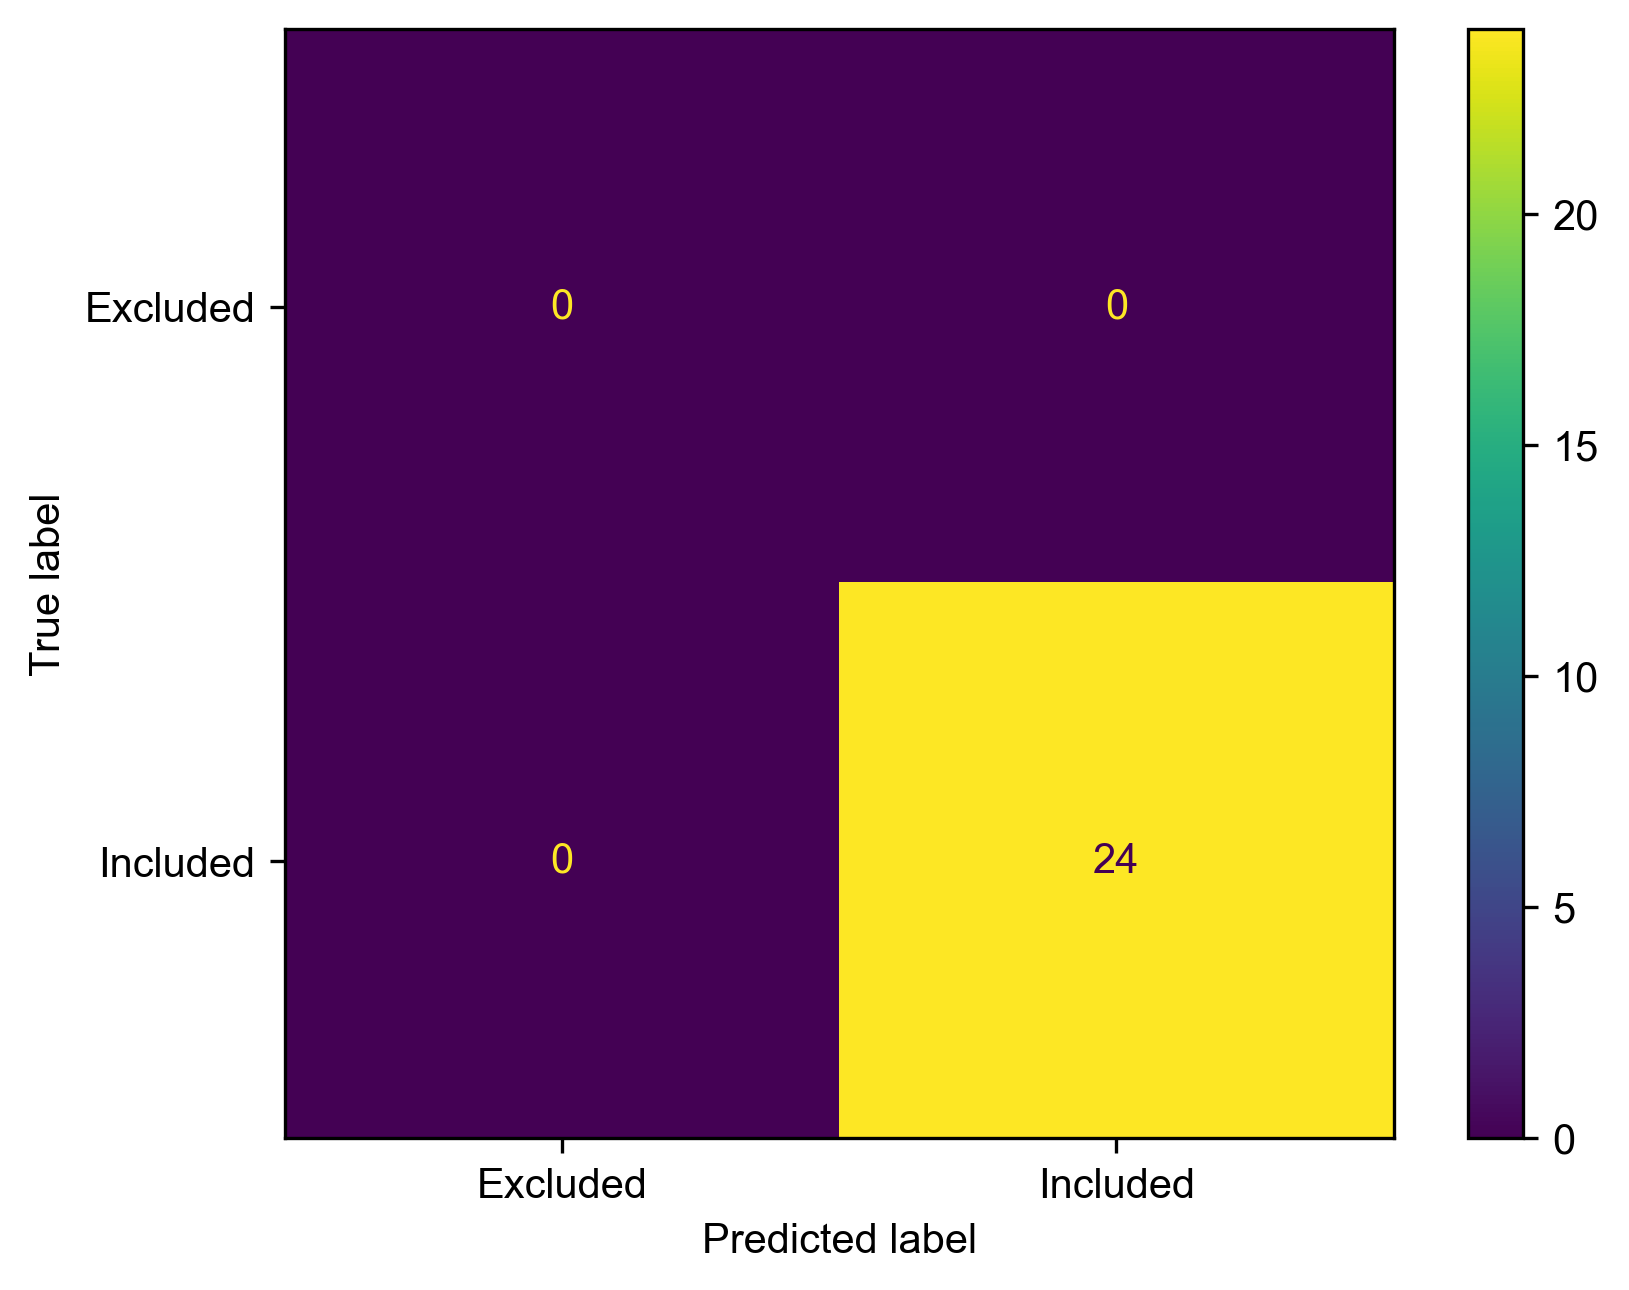

In [9]:
# Given a numpy array, output a confusion matrix with truth and model output labels

import numpy as np
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.sans-serif'] = "Arial"

def run_analysis(var, trial=False): 

    variable = performance_by_variable[var] 
    print(variable)
    tp = variable['TP']
    fn = variable['FN']
    fp = variable['FP']
    tn = variable['TN']

    cm = np.array(
        [[tp, fn],
        [fp, tn]]
    )
    
    if trial:
        # Variable in question is TRIAL ELIGIBILITY (i.e. The patient is eligible for trial NCT000000000)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Eligible", "Not Eligible"])
        cm_display.plot()
        
    else:
        # Variable in question is a CRITERION (i.e. The patient has a history of severe allergy to study drug.)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Excluded", "Included"])
        cm_display.plot()
    
    # Calculate MCC, sensitivity, and specificity.
    # In practice, an MCC score above 0.3 is considered moderate, and a score above 0.5 is considered strong. 
    # MCC is a measure of the quality of binary (two-class) classifications that ranges from -1 to +1.  

    if tp+fp and tp+fn and tn+fp and tn+fn:
        mcc = ((tp * tn) - (fp * fn))/((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**(0.5)
    else:
        mcc = 'Not calculable'
    sensitivity = tp / (tp + fn) if tp + fn else 0
    specificity = tn / (tn + fp) if tn + fp else 0
    
    print('=============')
    print('Variable: ', var)
    print('TN: ', tn)
    print('TP: ', tp)
    print('FN: ', fn)
    print('FP: ', fp)
    print('Matthew Correlation Coefficient: ', mcc)
    print('Sensitivity: ', sensitivity)
    print('Specificity: ', specificity)
    print()

trial_list = {    
    'R2578 (Morpheus)': {
        'col': 'R2578 Preliminary Eligibility (Morpheus)',
    },
    'S7260 (ARC-8)': {
        'col': 'S7260 Preliminary Eligibility (ARC-8)',
    },
    'S9513 (Chemo4METPANC)': {
        'col': 'S9513 Preliminary Eligibility (Chemo4METPANC)',
    },
    'T5285 (Bethanechol)': {
        'col': 'T5285 Preliminary Eligibility (Bethanechol)',
    },
    'T5973 (TIGeR-PaC)': { 
        'col': 'T5973 Preliminary Eligibility (TIGeR-PaC)',
    },
    'U1236 (Panbela)': {
        'col': 'U1236 Preliminary Eligibility (Panbela)',
    },
    'U4206 (AIRPanc)': {
        'col': 'U4206 Preliminary Eligibility (AIRPanc)',
    },
    'U5427 (Vaccine)': {
        'col': 'U5427 Preliminary Eligibility (Vaccine)',
    },
    'U6715 (CA-4948)': {
        'col': 'U6715 Preliminary Eligibility (CA-4948)',
    }
}

run_analysis('Age')

# run_analysis('U4206 (AIRPanc)', trial=True)


# Figure 2. Sensitivity and Specificity

R2578 (Morpheus)
7/8
S7260 (ARC-8)
9/10
S9513 (Chemo4METPANC)
7/7
T5285 (Bethanechol)
4/4
T5973 (TIGeR-PaC)
1/1
U1236 (Panbela)
8/9
U4206 (AIRPanc)
N/A
U5427 (Vaccine)
3/3
U6715 (CA-4948)
0/1


/var/folders/dd/j_8y2z7x2xd3fmsqjwrl_y7w0000gn/T/ipykernel_29668/529952269.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([(abs(tick)) for tick in ticks])


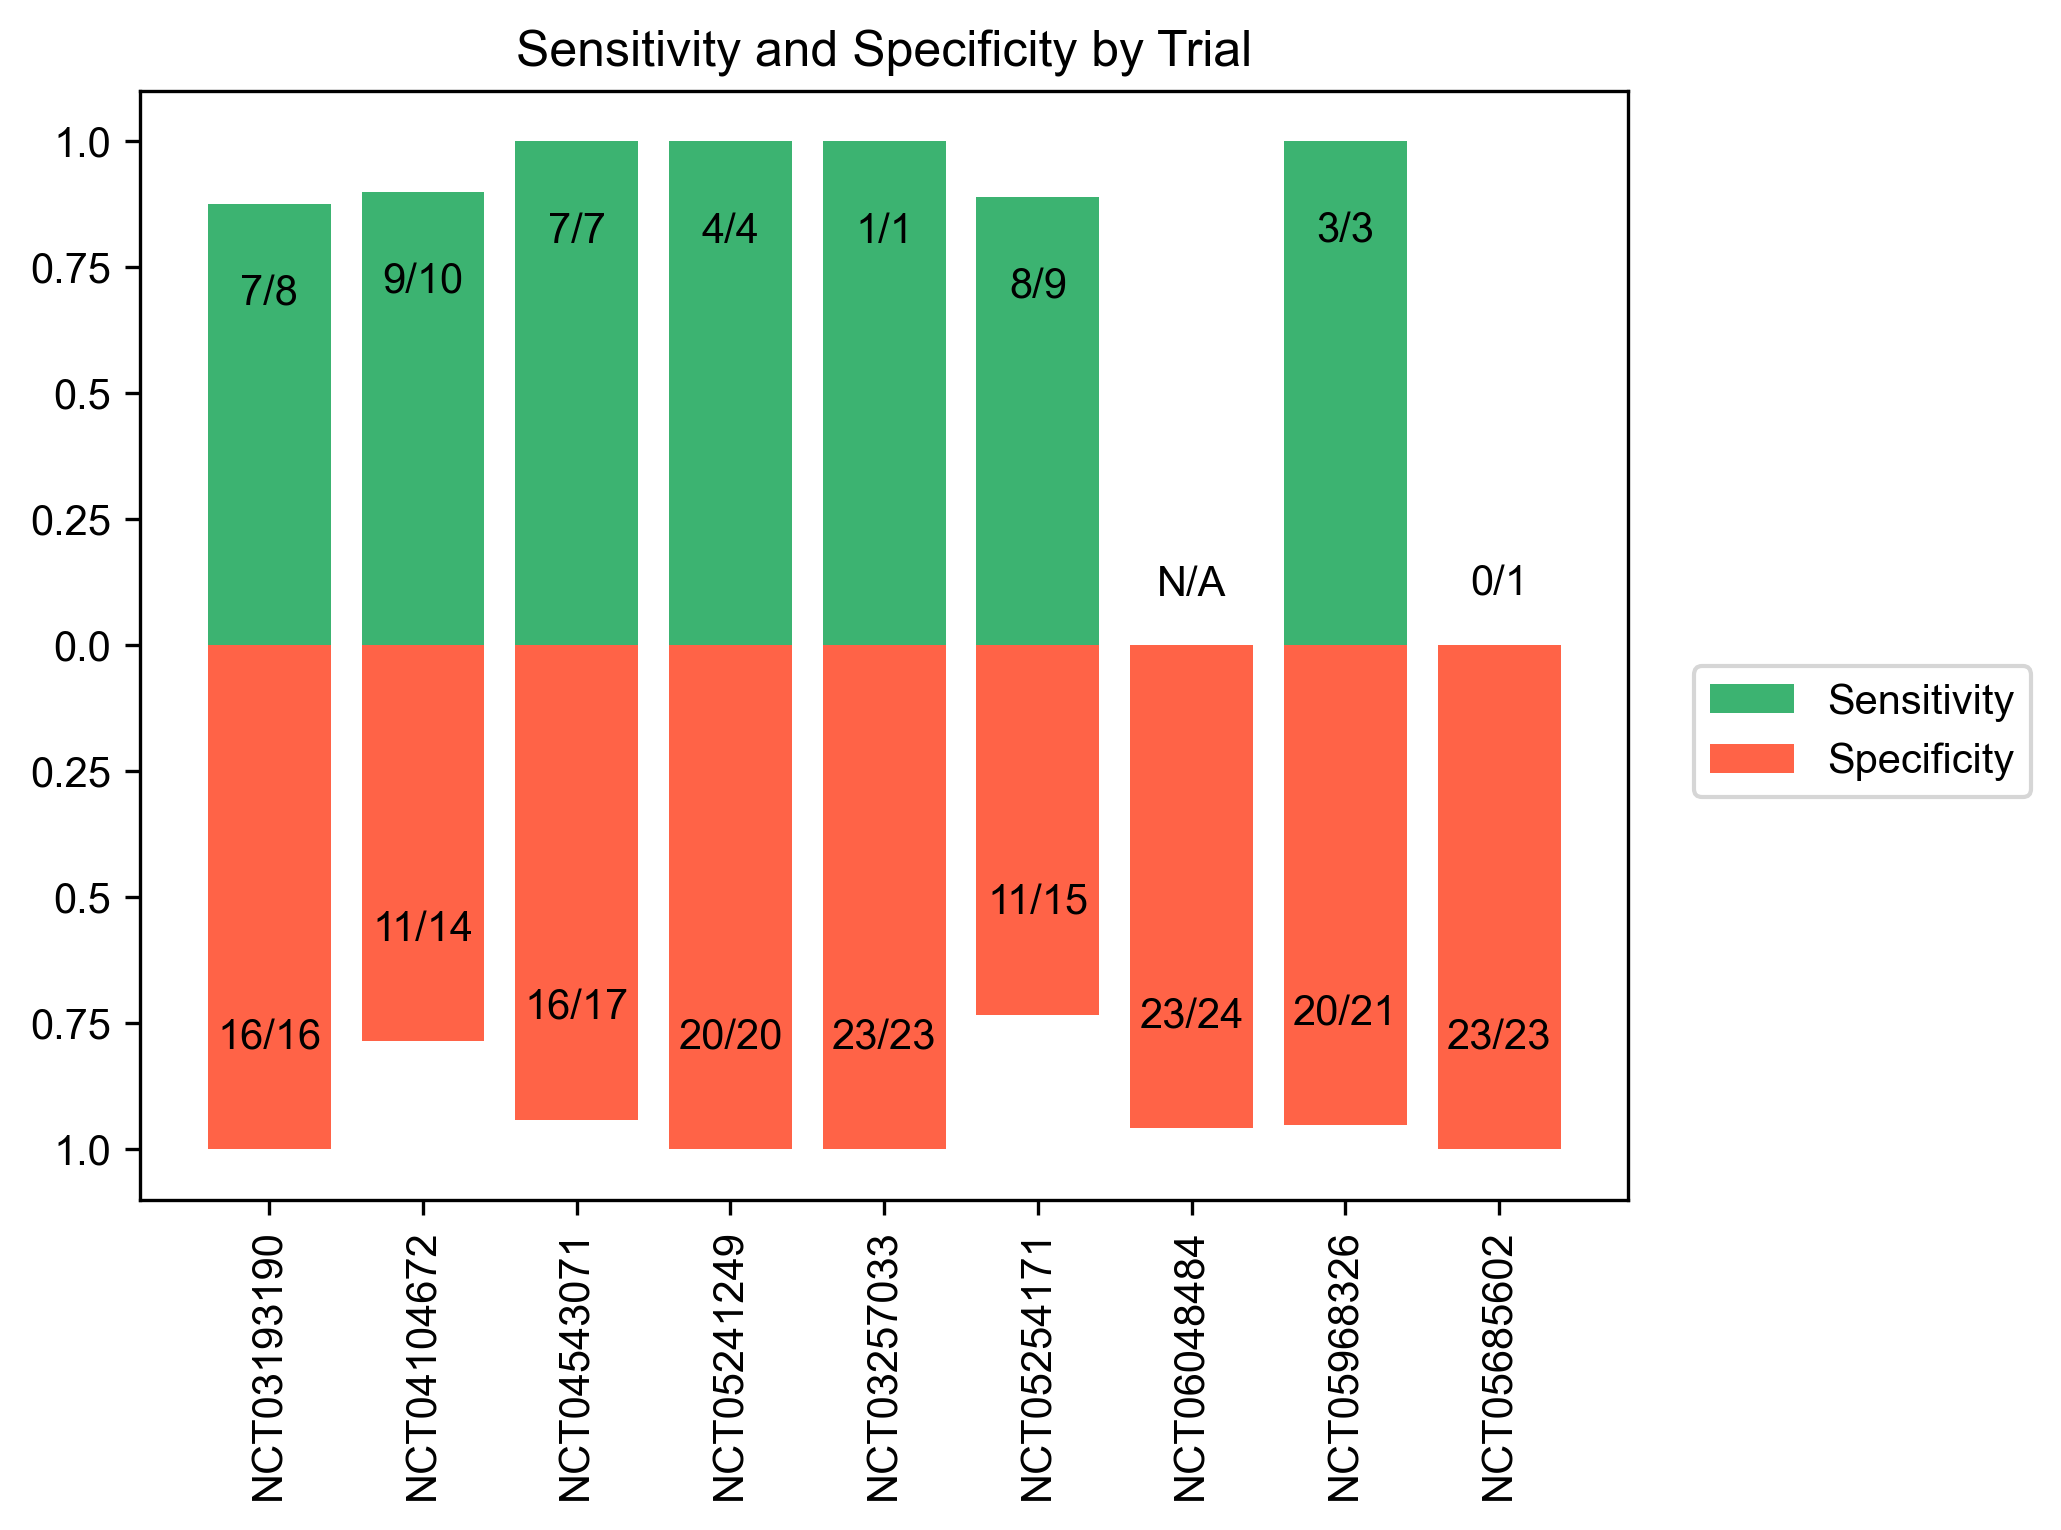

In [10]:
# Make a numpy array of all the sensitivities by trial

sens_array = []
sens_label_array = []

spec_array = []
spec_label_array = []

variables = []
keys_to_visualize = ['R2578 (Morpheus)', 'S7260 (ARC-8)', 'S9513 (Chemo4METPANC)', 'T5285 (Bethanechol)', 'T5973 (TIGeR-PaC)', 'U1236 (Panbela)', 'U4206 (AIRPanc)', 'U5427 (Vaccine)', 'U6715 (CA-4948)']
# keys_to_visualize = ['Age'] # Replace with whichever keys you want to look at 

trial_labels = {    
    'R2578 (Morpheus)': 'NCT03193190',
    'S7260 (ARC-8)': 'NCT04104672',
    'S9513 (Chemo4METPANC)': 'NCT04543071',
    'T5285 (Bethanechol)': 'NCT05241249',
    'T5973 (TIGeR-PaC)': 'NCT03257033',
    'U1236 (Panbela)': 'NCT05254171',
    'U4206 (AIRPanc)': 'NCT06048484',
    'U5427 (Vaccine)': 'NCT05968326',
    'U6715 (CA-4948)': 'NCT05685602'
}

for key, val in performance_by_variable.items():
    if key not in keys_to_visualize:
        continue      
    print(key)
    tp = val['TP']
    fn = val['FN']
    fp = val['FP']
    tn = val['TN']

    
    sensitivity = tp / (tp + fn) if tp + fn else 0
    sensitivity_label = "{num}/{denom}".format(num=tp, denom=tp+fn) if tp + fn else 'N/A'
        
    specificity = tn / (tn + fp) if tn + fp else 0
    specificity_label = "{num}/{denom}".format(num=tn, denom=tn+fp) if tn + fp else 'N/A'

    
    sens_array.append(sensitivity)
    sens_label_array.append(sensitivity_label)

    spec_array.append(specificity)
    spec_label_array.append(specificity_label)

    variables.append(trial_labels[key])
    print(sensitivity_label)
    


# Make a numpy array of all the specificities by trial

y = np.array(variables)
d_1 = np.array(sens_array) # sensitivity
d_2 = np.array(spec_array)*-1 # specificity


fig, ax = plt.subplots()
ax.bar(y, d_1, label="Sensitivity", color = "mediumseagreen")
ax.bar(y, d_2, label="Specificity", color = "tomato")
# Formatting x labels

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.03, 0.5))
plt.title("Sensitivity and Specificity by Trial")

# plt.tight_layout()

txt= ''

fig.text(0.1, 0.85, txt, ha='left')

# Use absolute value for y-ticks
ticks =  ax.get_yticks()
ax.set_yticklabels([(abs(tick)) for tick in ticks])

# Want to label each bar (above and below with the number in that group and the total) 
for i in range(len(d_1)):
    if d_1[i] == 0:
        ax.text(y[i], +0.1, sens_label_array[i], ha='center')
    else:
        ax.text(y[i], d_1[i]-0.2, sens_label_array[i], ha='center')
for i in range(len(d_2)):   
    if d_2[i] == 0:
        ax.text(y[i], -0.1, spec_label_array[i], ha='center')
    else:
        ax.text(y[i], d_2[i]+0.2, spec_label_array[i], ha='center')
    



In [6]:
definitions_json = {
   "Age":"The patient's age is less than 18",
   "Diagnosis 0":"The patient has a diagnosis of pancreatic adenocarcinoma",
   "Diagnosis 1":"The patient has a diagnosis of pancreatic acinar cell carcinoma",
   "Diagnosis 2":"The patient has a diagnosis of pancreatic islet cell carcinoma",
   "Diagnosis 3":"The patient has a diagnosis of pancreatic neuroendocrine tumor",
   "BRCA Status":"The patient is BRCA positive",
   "Resectability 0":"The patient's pancreatic cancer is resectable",
   "Resectability 1":"The patient's pancreatic cancer is borderline resectable",
   "Resectability 2":"The patient's pancreatic cancer is locally advanced",
   "Resectability 3":"The patient's pancreatic cancer is metastatic",
   "Resectability 4":"The patient's pancreatic cancer is metastatic with lesions in the central nervous system",
   "Prior therapy 0":"The patient has had prior adjuvant, neoadjuvant, or induction treatment for pancreatic cancer.",
   "Prior therapy 1":"The patient has had prior chemotherapy for pancreatic cancer.",
   "Prior therapy 2":"The patient has had prior radiotherapy for pancreatic cancer.",
   "Prior therapy 4":"The patient has had prior T-cell costimulation or immune checkpoint blockade therapies for pancreatic cancer.",
   "Prior therapy 5":"The patient has had prior hormonal therapy for pancreatic cancer.",
   "Prior therapy 6":"The patient has had prior surgical resection for pancreatic cancer.",
   "Notable outcomes 0":"The patient has had disease progression on 5-FU for metastatic or unresectable pancreatic ductal adenocarcinoma.",
   "Notable outcomes 1":"The patient has a macroscopically complete (R0 or R1 resection) within 6-12 weeks",
   "Notable outcomes 2":"The patient has had clinically significant adverse events excluding alopecia and Grade <=2 peripheral neuropathy.",
   "ECOG greater than 1":"ECOG performance status (PS) is greater than 1.",
   "ECOG greater than 2":"ECOG performance status (PS) is greater than 2.",
   "PMH_0":"The patient has a history of uncontrolled intercurrent illness.",
   "PMH_01":"The patient has a history of uncontrolled hypertension.",
   "PMH_02":"The patient has a history of vasomotor instability.",
   "PMH_03":"The patient has a history of seizure disorder.",
   "PMH_04":"The patient has a history of retinopathy or high risk of retinal detachment.",
   "PMH_05":"The patient has a history of uncontrolled tumor-related pain.",
   "PMH_06":"The patient has a history of leptomeningeal disease.",
   "PMH_07":"The patient has a history of Grade >=2 neuropathy.",
   "PMH_08":"The patient has a history of severe obstructive pulmonary disease or interstitial lung disease, pulm fibrosis, pulmonary hypersensitivity reaction, or active tuberculosis.",
   "PMH_09":"The patient has a history of uncontrolled pleural effusion, pericardial effusion, or ascites requiring recurrent drainage.",
   "PMH_10":"The patient has a history of GI condition which could impair absorption or ability to ingest study drug (i.e. evidence of GI obstruction).",
   "PMH_11":"The patient has a history of peptic ulcer disease.",
   "PMH_12":"The patient has a history of inflammatory dz of colon and rectum, severe uncontrolled diarrhea, Celiac disease.",
   "PMH_13":"The patient has a history of rhabdomyolysis or elevated creatine phosphokinase (CPK).",
   "PMH_14":"The patient has a history of clinically significant liver disease including alc hepatitis, cirrhosis, FLD, inherited liver dz.",
   "PMH_15":"The patient has a history of Gilbert's disease",
   "PMH_16":"The patient has a history of uncontrolled hypercalcemia (on labs or symptomatic, requiring bisphosphonate therapy for hyperCa)",
   "PMH_17":"The patient has a history of uncontrolled hyperthyroidism (clinical hyperthyroidism uncontrolled by oral medication)",
   "PMH_18":"The patient has a history of allogeneic organ or stem cell transplant",
   "PMH_19":"The patient has a history of DVT, portal vein occlusion, PE, or other thromboembolic event during screening",
   "PMH_20":"The patient has a history of Grade ≥ 3 hemorrhage or bleeding event within 28 days prior to initiation of study treatment",
   "PMH_21":"The patient has a history of active autoimmune disease, uncontrolled psoriasis, porphyria, proximal myopathy or neuropathy (excluding hypothyroidism on thyroid replacement, controlled T1DM, well-controlled skin conditions)",
   "PMH_22":"The patient has a recent history of active infections requiring systemic therapy",
   "Other Malignancy":"The patient has a history of other malignancy within 2 years that does not include malignancies with a low rate of metastatic spread.",
   "Cardiac history 0":"The patient has had active/symptomatic coronary artery disease, myocardial infarction, stroke, or PCI within 2 years.",
   "Cardiac history 1":"The patient has a history of life-threatening arrhythmia.",
   "Cardiac history 2":"The patient has a history of EF <40% within last 3 months.",
   "Cardiac history 3":"The patient has a history of NYHA Class III or IV congestive heart failure within 3 months.",
   "PSxH 0":"The patient has had GI/colon resection surgery within the last 12 months.",
   "PSxH 1":"The patient has had urinary bladder surgery within the last 12 months.",
   "PSxH 2":"The patient has a history of splenectomy or functional asplenia.",
   "PSxH 3":"The patient has had major surgery requiring general anesthesia within the last 12 months.",
   "Psych Hx 0":"The patient has a psychiatric condition limiting their ability to participate in the trial.",
   "Psych Hx 1":"The patient has had severe depression requiring hospitalization in the last two years OR has any history of SA.",
   "Medications 0":"The patient is taking a moderate inhibitor, string inhibitor, moderate inducer, or strong inducer of CYP3A4.",
   "Medications 1":"The patient is taking an acetylcholinesterase inhibitor.",
   "Medications 2":"The patient is taking metformin.",
   "Medications 3":"The patient is taking hydroxychloroquine.",
   "Medications 4":"The patient is taking anticoagulation that is actively being adjusted.",
   "Medications 5":"The patient is taking abrivudine or sorivudine.",
   "Medications 6":"The patient is taking a UGT1A1 inhibitor or inducer.",
   "Medications 7":"The patient is taking systemic immunosuppression, such as corticosteroids, cyclophosphamide, azathioprine, methotrexate, thalidomide, calcineurin inhibitors, and anti-tumor necrosis factor alpha agents.",
   "Medications 8":"The patient is taking greater than 10mg prednisone or steroid equivalent daily.",
   "Investigational Medications":"The patient has taken other investigational agents within 4 weeks.",
   "Allergies 0":"The patient has a documented allergy to compounds of similar chemical or biologic composition to CA-4948.",
   "Allergies 1":"The patient has a documented allergy to gemcitabine.",
   "Allergies 2":"The patient has a documented allergy to nab-paclitaxel.",
   "Allergies 3":"The patient has a documented allergy to oxaliplatin, irinotecan, leucovorin, fluorouracil, or pegfilgrastim.",
   "Allergies 4":"The patient has a documented allergy to chimeric or humanized antibodies or fusion proteins.",
   "Allergies 5":"The patient has a documented allergy to Chinese hamster ovary cell products or recombinant human antibodies.",
   "Vitals":"The patient has bradycardia with resting HR <50, hypotension with resting SBP <90mmHg, or vasomotor instability.",
   "Hemoglobin":"True if hemoglobin is less than 9.0",
   "ANC":"ANC < 1.5E9/L",
   "Lymphocyte count":"Lymphocyte count < 0.5E9/L",
   "Platelets":"Platelets < 100E9/L",
   "Tbili":"Total bili > 1.5x ULN or > 3x ULN in Gilbert disease",
   "AST/ALT":"AST and ALT > 3x upper limit of normal",
   "Coags":"PT, aPTT, or INR > 2.5x upper limit of normal",
   "Albumin":"Albumin < 3 g/dL",
   "GFR":"GFR < 60 mL/min",
   "CPK":"CPK > 2.5x upper limit of normal",
   "HIV Status":"The patient has tested positive for HIV",
   "Hep B Status":"The patient has active or symptomatic Hepatitis B",
   "Hep C Status":"The patient has active or symptomatic Hepatitis C",
   "Breastfeeding":"The patient is actively breastfeeding",
   "Imaging":"The patient's disease is unmeasurable on CT or MRI.",
   "Unsafe Bx":"The patient's disease is not feasible or safe for biopsy.",
   "Alternative Medicine":"The patient reports current or anticipated use of alternative medicine for the purpose of cancer treatment.",
   "Life expectancy":"The patient's life expectancy is less than 3 months.",
   "Radiation contraindications":"The patient has contraindications for SBRT including the following: GI mucosal infiltration, significant planned overlap with prior abdominal radiotherapy.",
   "Dihydropyrimidine dehydrogenase deficiency":"The patient has a documented complete dihydropyrimidine dehydrogenase (DPD) deficiency including homozygous or compound heterozygous mutations of DPYD genetic locus associated with DPD deficiency.",
   "Live attenuated vaccines":"The patient has been treated with a live attenuated vaccine within 4 weeks or anticipates a need for such tx during the study.",
   "DVT Testing":"There is concern for clot burden or DVT during the screening period and/or the patient is not on a stable anticoagulation regimen.",
   "Tumor Staging":"The patient's disease is higher stage than T3N2M0 (i.e. T4, N3, or M1).",
   "R2578 (Morpheus)":"The patient is eligible for trial NCT03193190",
   "S7260 (ARC-8)":"The patient is eligible for trial NCT04104672",
   "S9513 (Chemo4METPANC)":"The patient is eligible for trial NCT04543071",
   "T5285 (Bethanechol)":"The patient is eligible for trial NCT05241249",
   "T5973 (TIGeR-PaC)":"The patient is eligible for trial NCT03257033",
   "U1236 (Panbela)":"The patient is eligible for trial NCT05254171",
   "U4206 (AIRPanc)":"The patient is eligible for trial NCT06048484",
   "U5427 (Vaccine)":"The patient is eligible for trial NCT05968326",
   "U6715 (CA-4948)":"The patient is eligible for trial NCT05685602"
}

# Figure 3. Performance on Individual Characteristics

In [8]:
# Generate a table to represent sensitivity and specificity and total numerators/denominators for each criterion

# choose keys (might have to limit to 5 depending on table rules)
criteria_keys = ['Age', 'Resectability 0', 'ECOG greater than 2', 'Tbili', 'Notable outcomes 0', 'Medications 2', 'Hep B Status', 'Resectability 3']

# make a df with columns criterion, sensitivity, tp/tp+fn, specificity, tn/tn+fp, anything else???
criteria_table = []
# loop through keys
for key, val in performance_by_variable.items():
#     if key not in criteria_keys:
#         continue      
    tp = val['TP']
    fn = val['FN']
    fp = val['FP']
    tn = val['TN']

    sensitivity = tp / (tp + fn) if tp + fn else 0
    sensitivity_label = "{num}/{denom}".format(num=tp, denom=tp+fn) if tp + fn else 'N/A'
        
    specificity = tn / (tn + fp) if tn + fp else 0
    specificity_label = "{num}/{denom}".format(num=tn, denom=tn+fp) if tn + fp else 'N/A'
    
    criteria_table.append([definitions_json[key], sensitivity, sensitivity_label, specificity, specificity_label])
# add a row to the df for that variable

criteria_df = pandas.DataFrame(criteria_table, columns=['Criterion', 'Sensitivity (TP for exclusion)', 'Sensitivity Calculation', 'Specificity (TN for inclusion)', 'Specificity Calculation'])

# output as CSV
criteria_df.to_csv('./' + newpath + '/individial_criteria_table.csv')
print("If the model answers 'True', this means the criterion may exclude the patient.")
criteria_df

If the model answers 'True', this means the criterion may exclude the patient.


,Criterion,Sensitivity (TP for exclusion),Sensitivity Calculation,Specificity (TN for inclusion),Specificity Calculation
0,The patient's age is less than 18,0.000000,N/A,1.000000,24/24
1,The patient has a diagnosis of pancreatic aden...,1.000000,23/23,0.000000,0/1
2,The patient has a diagnosis of pancreatic acin...,0.000000,N/A,1.000000,24/24
3,The patient has a diagnosis of pancreatic isle...,0.000000,N/A,1.000000,24/24
4,The patient has a diagnosis of pancreatic neur...,0.000000,N/A,1.000000,24/24
...,...,...,...,...,...
100,The patient is eligible for trial NCT03257033,1.000000,1/1,1.000000,23/23
101,The patient is eligible for trial NCT05254171,0.888889,8/9,0.733333,11/15
102,The patient is eligible for trial NCT06048484,0.000000,N/A,0.958333,23/24
103,The patient is eligible for trial NCT05968326,1.000000,3/3,0.952381,20/21


# Figure 3, Table 4. Cost and Time Elapsed

path: RUN_1_090924_n5


,Assistant,Median Cost (USD),Median Total Tokens,Median Prompt Tokens,Median Completion Tokens
0,Eligibility,0.56 (0.52-0.62),96571.5 (87497.5-106799.0),88135.0 (79468.8-98427.5),8065.5 (7767.0-8282.8)
1,Ensembling,0.07 (0.07-0.08),10126.0 (9974.2-10465.8),8149.5 (7851.0-8366.8),2022.0 (1736.0-2545.0)
2,Binarization,0.04 (0.04-0.04),5622.5 (5276.0-6048.8),4689.0 (4403.0-5212.0),984.0 (773.0-984.0)
3,Total,0.67 (0.63-0.72),112266.5 (102982.0-122174.2),101205.5 (92098.5-111326.0),10975.0 (10718.5-11253.8)


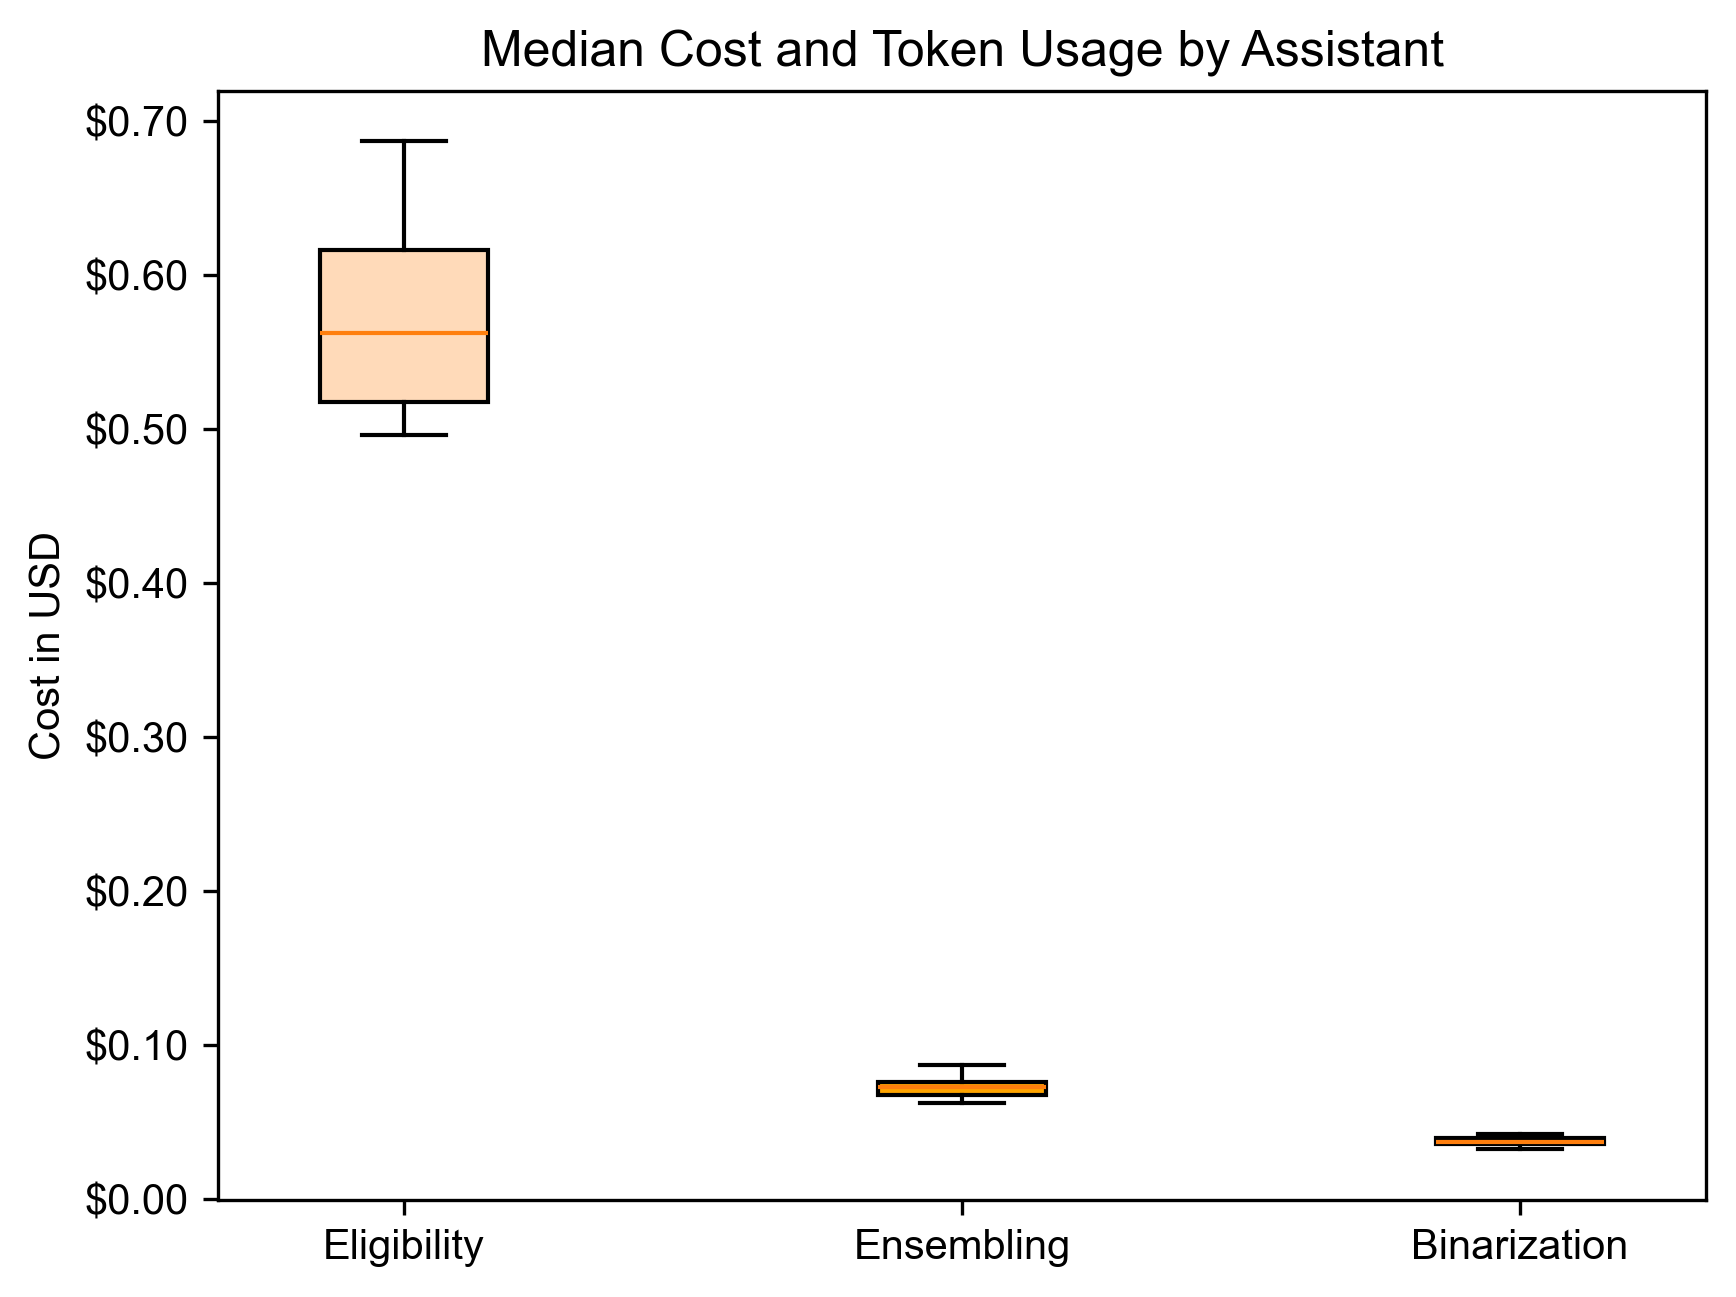

In [6]:
import matplotlib.ticker as ticker
import pandas
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 300

matplotlib.rcParams['font.sans-serif'] = "Arial"

path = input('path: ')

def get_total(key_suffix):
    usage = pandas.read_csv('./' + path + '/usage.csv')
    total_usage = usage['Eligibility ' + key_suffix] + usage['Ensembling ' + key_suffix] + usage['Binarization ' + key_suffix]
    if 'Cost' in key_suffix:
        quantiles = total_usage.quantile([.25, .5, .75]).round(2)
    else:
        quantiles = total_usage.quantile([.25, .5, .75]).round(1)
    return "{median} ({p25}-{p75})".format(median=quantiles[0.5], p25=quantiles[0.25], p75=quantiles[0.75])

def get_formatted_iqr(key):
    usage = pandas.read_csv('./' + path + '/usage.csv')
    q = [0.25, 0.5, 0.75]
    if 'Cost' in key:
        quantiles = usage[key].quantile([.25, .5, .75]).round(2)
    else:
        quantiles = usage[key].quantile([.25, .5, .75]).round(1)
    return "{median} ({p25}-{p75})".format(median=quantiles[0.5], p25=quantiles[0.25], p75=quantiles[0.75])

def display_cost():
    usage = pandas.read_csv('./RUN_1_090924_n5/usage.csv')
    
    eligibility_cost = get_formatted_iqr('Eligibility Cost')
    ensembling_cost = get_formatted_iqr('Ensembling Cost')
    binarization_cost = get_formatted_iqr('Binarization Cost')
#     cost_sum = e

    eligibility_tokens = get_formatted_iqr('Eligibility Total Tokens')
    ensembling_tokens = get_formatted_iqr('Ensembling Total Tokens')
    binarization_tokens = get_formatted_iqr('Binarization Total Tokens')

    eligibility_prompt_tokens = get_formatted_iqr('Eligibility Prompt Tokens')
    ensembling_prompt_tokens = get_formatted_iqr('Ensembling Prompt Tokens')
    binarization_prompt_tokens = get_formatted_iqr('Binarization Prompt Tokens')

    eligibility_completion_tokens = get_formatted_iqr('Eligibility Completion Tokens')
    ensembling_completion_tokens = get_formatted_iqr('Ensembling Completion Tokens')
    binarization_completion_tokens = get_formatted_iqr('Binarization Completion Tokens')

    cost_df = usage[['Eligibility Cost','Ensembling Cost','Binarization Cost']]
    tokens_df = usage[['Eligibility Total Tokens','Ensembling Total Tokens','Binarization Total Tokens']]
    prompt_tokens_df = usage[['Eligibility Prompt Tokens','Ensembling Prompt Tokens','Binarization Prompt Tokens']]
    completion_tokens_df = usage[['Eligibility Completion Tokens','Ensembling Completion Tokens','Binarization Completion Tokens']]

    median_data = {
        'Assistant': ['Eligibility', 'Ensembling', 'Binarization', 'Total'],
        'Median Cost (USD)': [eligibility_cost,ensembling_cost,binarization_cost, get_total('Cost')],
        'Median Total Tokens': [eligibility_tokens,ensembling_tokens,binarization_tokens, get_total('Total Tokens')],
        'Median Prompt Tokens': [eligibility_prompt_tokens,ensembling_prompt_tokens,binarization_prompt_tokens, get_total('Prompt Tokens')],
        'Median Completion Tokens': [eligibility_completion_tokens,ensembling_completion_tokens,binarization_completion_tokens, get_total('Completion Tokens')],

    }
    
    median_df = pandas.DataFrame(median_data)

    colors = ['peachpuff', 'orange', 'tomato']
    
    fig, ax1 = plt.subplots()
    positions1 = [1, 2.5, 4] 
    cost_plot = ax1.boxplot(cost_df, positions = positions1, patch_artist=True)
    plt.title("Median Cost and Token Usage by Assistant")
    ax1.set_xticklabels(['Eligibility', 'Ensembling', 'Binarization'])
    formatter = ticker.FormatStrFormatter('$%1.2f')
    ax1.yaxis.set_major_formatter(formatter)
    plt.ylabel("Cost in USD")


#     ax2 = ax1.twinx()
    positions2 = [1.2, 2.7, 4.2] 
#     token_plot = ax.boxplot(tokens_df, positions = positions2, patch_artist=True)
#     ax2.set_ylabel("Tokens")
#     ax2.set_xticklabels(['Eligibility', 'Ensembling', 'Binarization'])
    
    for patch, color in zip(cost_plot['boxes'], colors):
        patch.set_facecolor(color)
    
    
    median_df.to_csv('./' + path + '/median_cost.csv')
    return median_df

display_cost()

# Get time elapsed

In [134]:
path = input('path: ')

def get_time_elapsed():
    df = pandas.read_csv('./' + path + '/model_outputs.csv')
    return df['Elapsed Time'].quantile([.25, .5, .75])

get_time_elapsed()

# 137.66058628057363, RUN_1_090924_n5
0.25    130.045431
0.50    137.660586
0.75    146.043555


path: RUN_1_090924_n5


0.25    130.045431
0.50    137.660586
0.75    146.043555
Name: Elapsed Time, dtype: float64

/var/folders/dd/j_8y2z7x2xd3fmsqjwrl_y7w0000gn/T/ipykernel_29668/1217269608.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(error_categories, palette=palette, orient='h')


Error Category
Human Error          0.317073
Hallucination        0.280488
Misinterpretation    0.170732
Clinical Judgment    0.146341
Note Unclear         0.060976
Prompt Unclear       0.024390
Name: count, dtype: float64

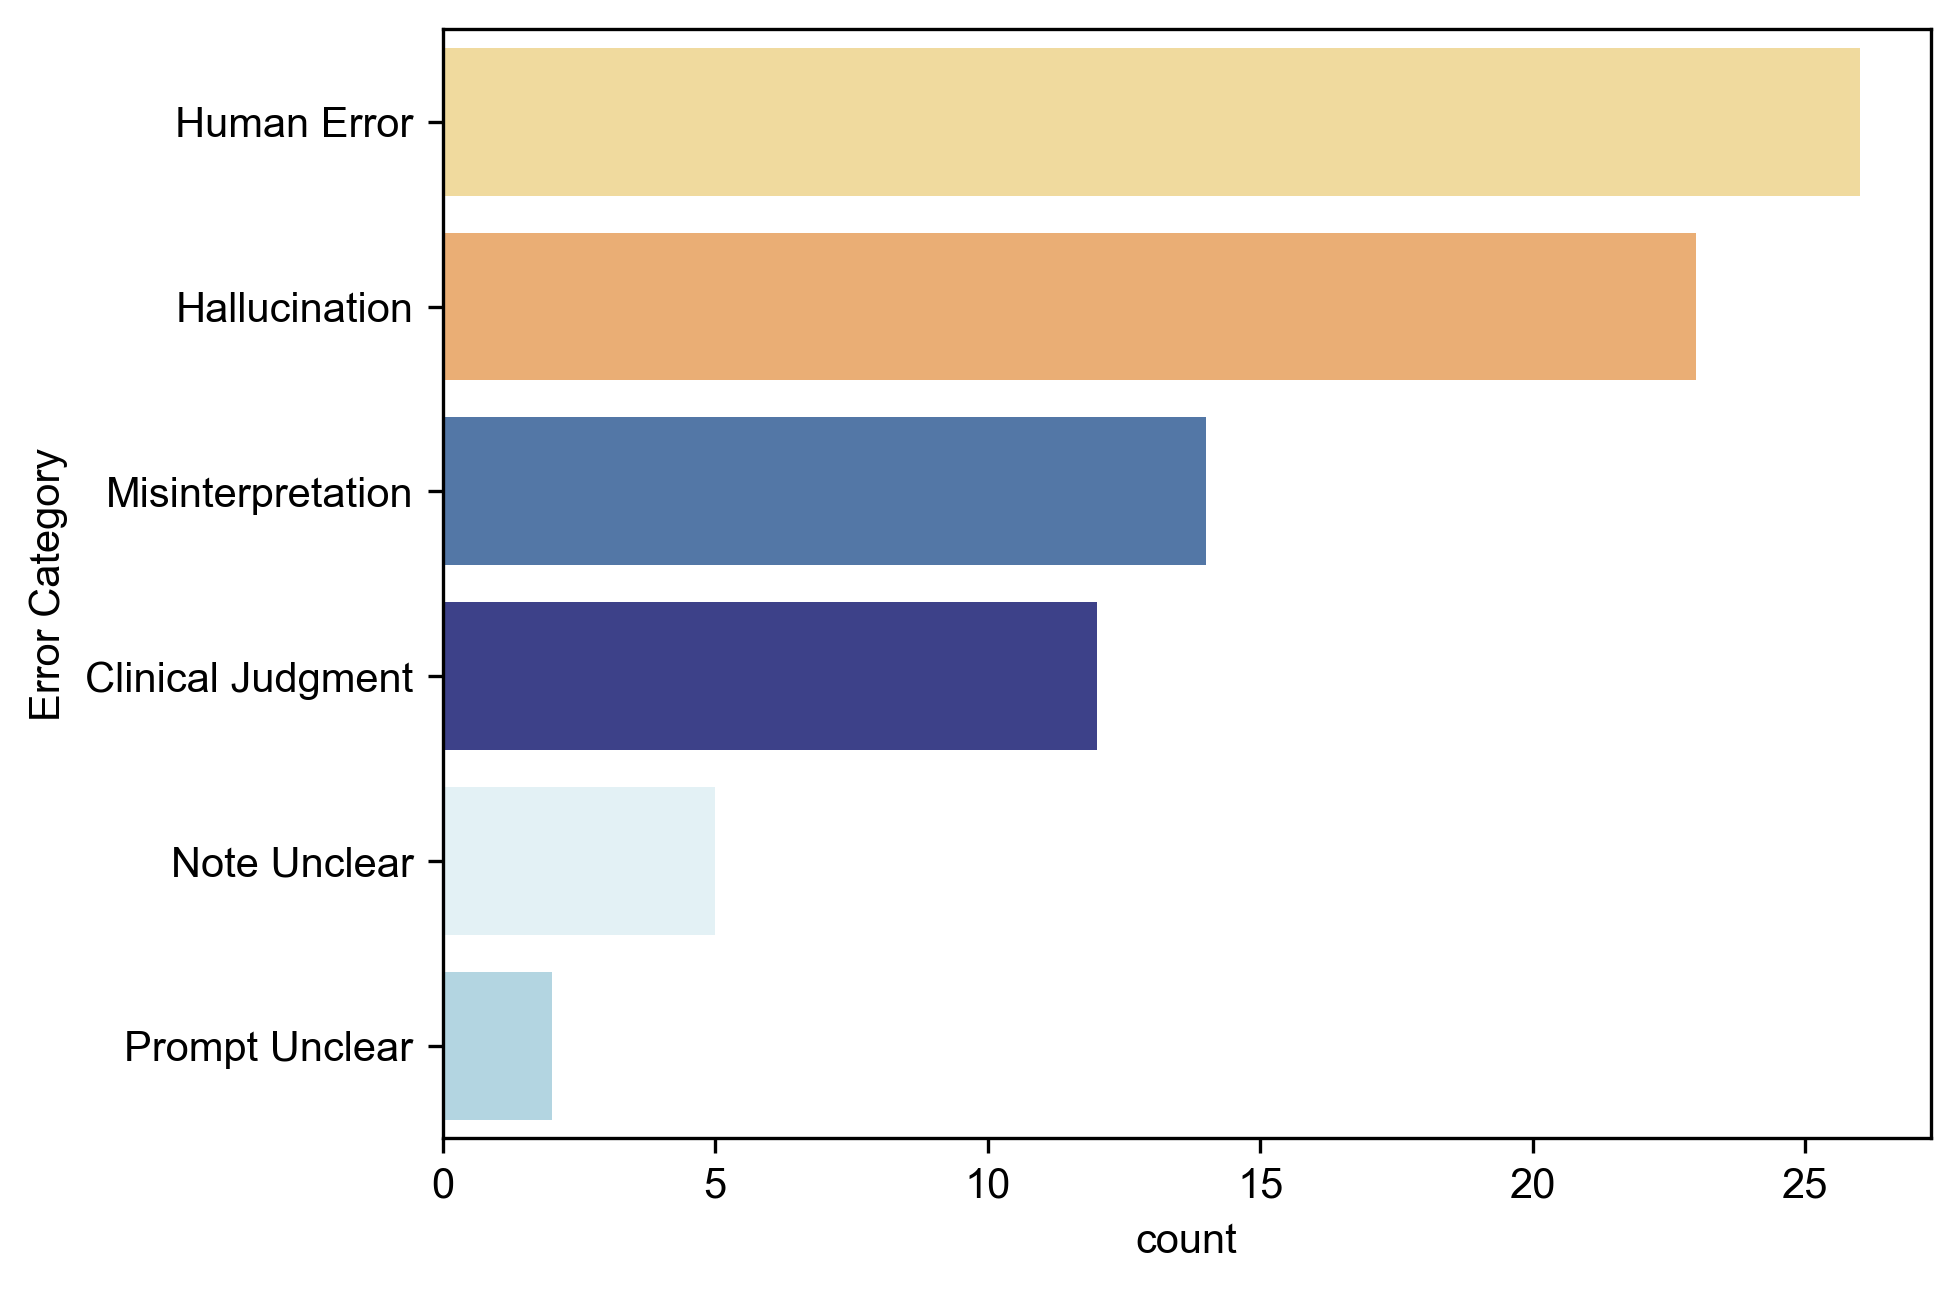

In [12]:
import pandas 
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

df = pandas.read_csv('./categorizing errors.csv')

palette = ["#fee090", "#fdae61", "#4575b4", "#313695", "#e0f3f8", "#abd9e9"]

trial_keys = [
    'R2578 (Morpheus)',
    'S7260 (ARC-8)',
    'S9513 (Chemo4METPANC)',
    'T5285 (Bethanechol)',
    'T5973 (TIGeR-PaC)',
    'U1236 (Panbela)',
    'U4206 (AIRPanc)',
    'U5427 (Vaccine)',
    'U6715 (CA-4948)']

trial_list = {    
    'R2578 (Morpheus)': {
        'col': 'R2578 Preliminary Eligibility (Morpheus)',
    },
    'S7260 (ARC-8)': {
        'col': 'S7260 Preliminary Eligibility (ARC-8)',
    },
    'S9513 (Chemo4METPANC)': {
        'col': 'S9513 Preliminary Eligibility (Chemo4METPANC)',
    },
    'T5285 (Bethanechol)': {
        'col': 'T5285 Preliminary Eligibility (Bethanechol)',
    },
    'T5973 (TIGeR-PaC)': { 
        'col': 'T5973 Preliminary Eligibility (TIGeR-PaC)',
    },
    'U1236 (Panbela)': {
        'col': 'U1236 Preliminary Eligibility (Panbela)',
    },
    'U4206 (AIRPanc)': {
        'col': 'U4206 Preliminary Eligibility (AIRPanc)',
    },
    'U5427 (Vaccine)': {
        'col': 'U5427 Preliminary Eligibility (Vaccine)',
    },
    'U6715 (CA-4948)': {
        'col': 'U6715 Preliminary Eligibility (CA-4948)',
    }
}

error_counts = {
    'Clinical Judgment': [0,0], # needs fix
    'Prompt Unclear': [0,0],
    'Note Unclear': [0,0], # needs fix
    'Misinterpretation': [0,0],
    'Hallucination': [0,0],
    'Human Error': [0,0]
}

for i in range(len(df)):
    if df.iloc[i]['Error ID'] != '-':
        if df.iloc[i]['Error Variable'] in trial_keys:
            error_counts[df.iloc[i]['Error Category']][1] += 1
        else:
            error_counts[df.iloc[i]['Error Category']][0] += 1

fig, ax = plt.subplots()

hallucinations = df[df['Error Category']=='Hallucination']['Error Variable'].value_counts()
# hallucinations.plot(kind='barh', title='Hallucinations by Variable Missed')

misinterpretations = df[df['Error Category']=='Misinterpretation']['Error Variable'].value_counts()
# misinterpretations.plot(kind='barh', title='Misinterpretations by Variable Missed')

human_errors = df[df['Error Category']=='Human error']['Error Variable'].value_counts()
# human_errors.plot(kind='barh', title='Human Errors by Variable Missed')

panbela_errors = df[df['Error Variable']=='U1236 (Panbela)']['Error Category'].value_counts()
# panbela_errors.plot(kind='barh', title='Panbela Trial Errors by Error Category')

error_categories = df['Error Category'].value_counts()
ax = sns.barplot(error_categories, palette=palette, orient='h')
error_categories / 82



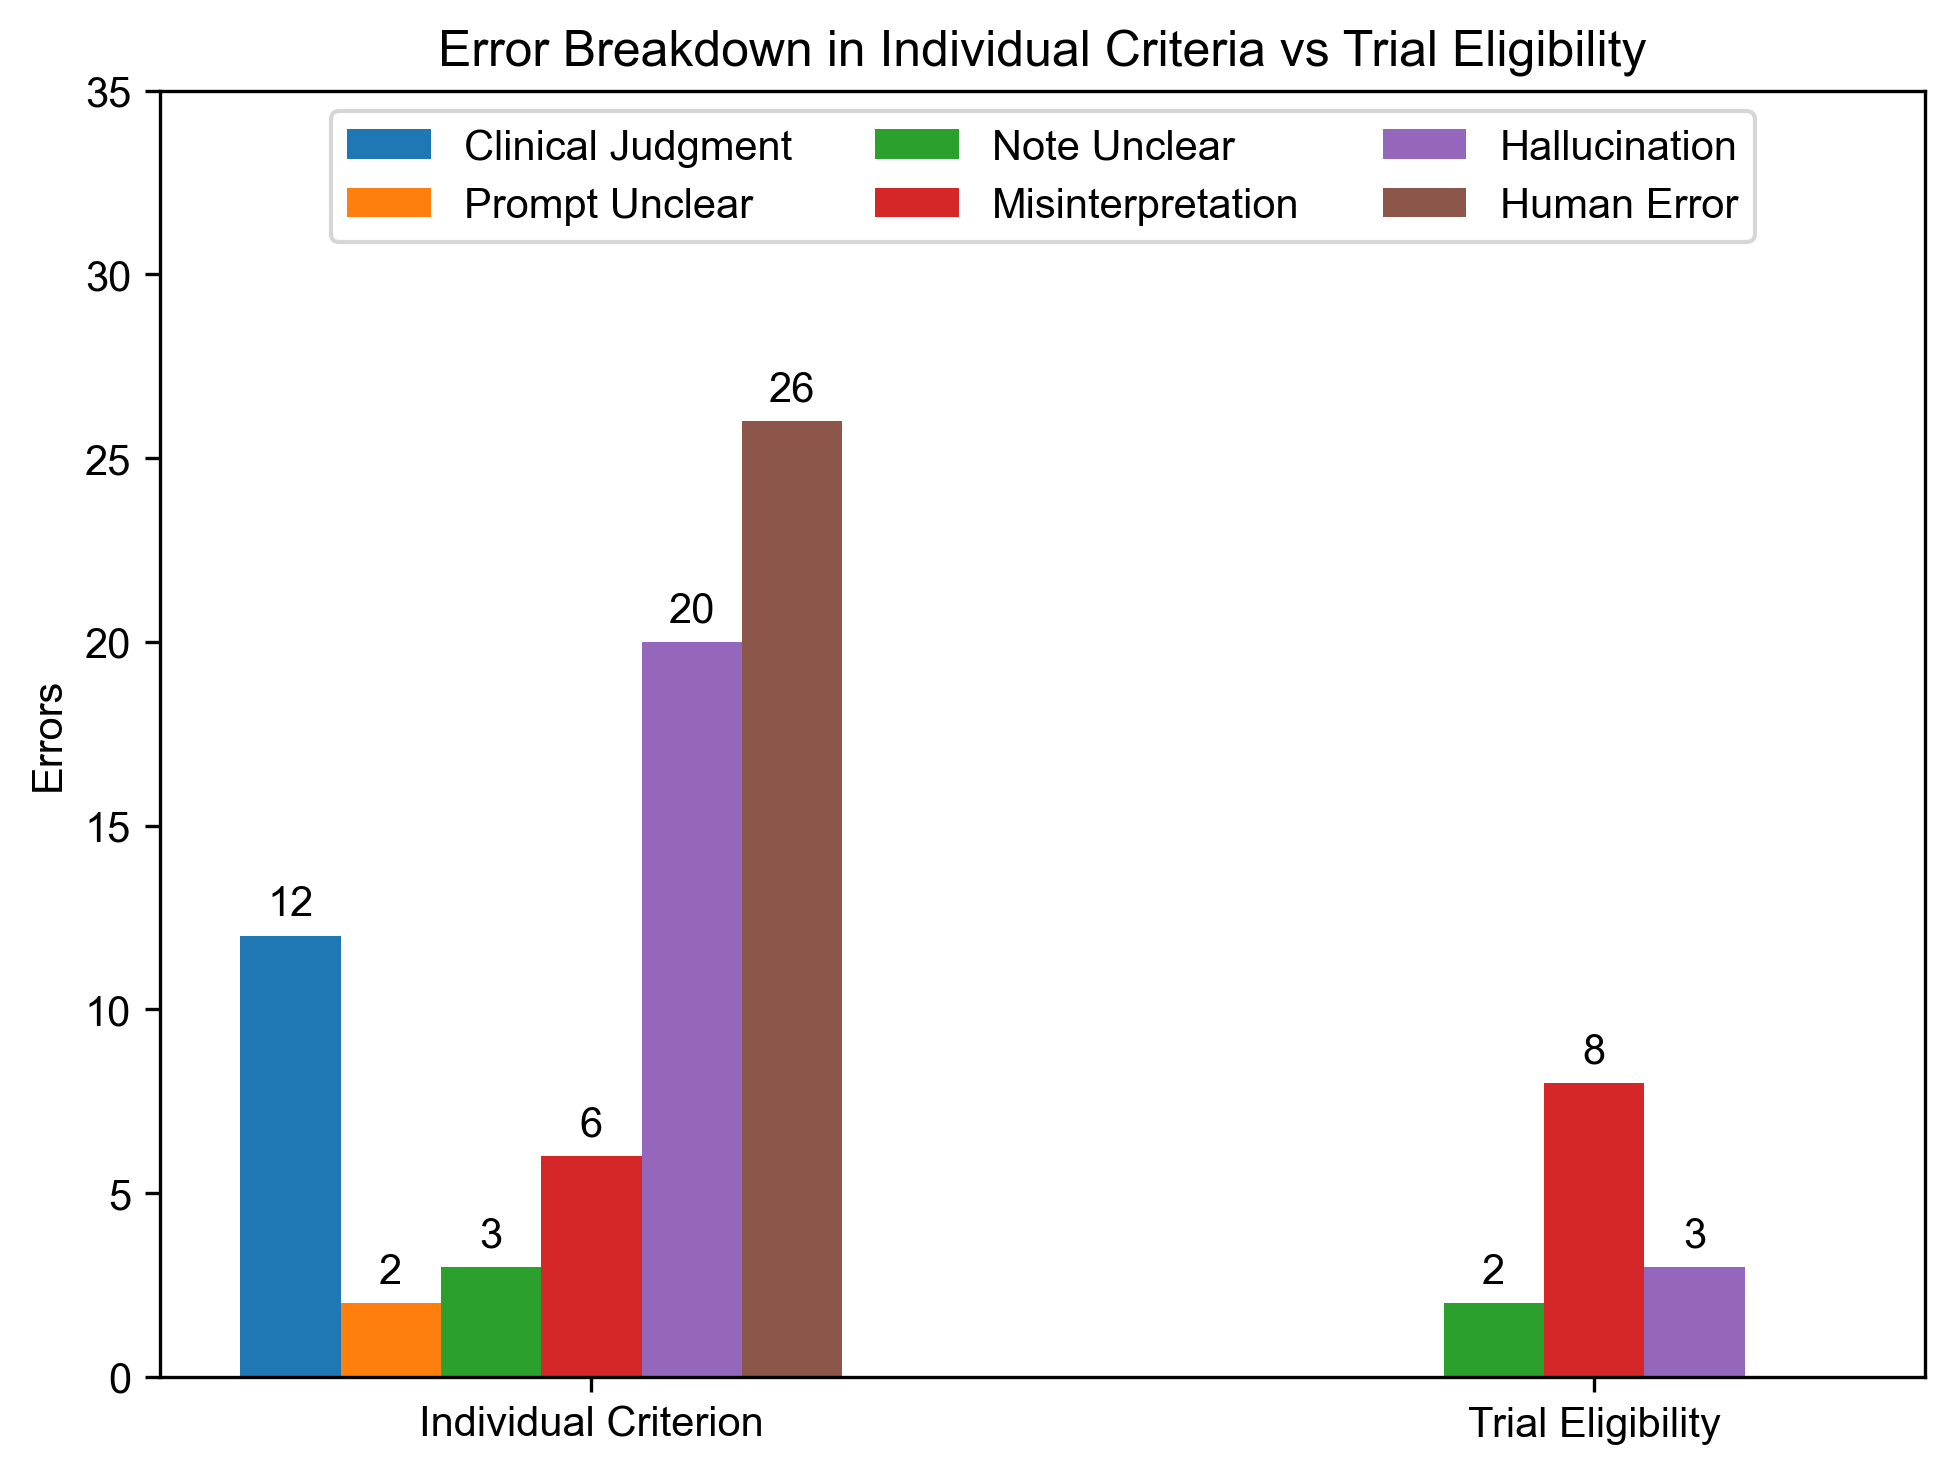

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams['figure.dpi'] = 300

matplotlib.rcParams['font.sans-serif'] = "Arial"

groups = ("Individual Criterion", "Trial Eligibility")


x = np.arange(len(groups))  # the label locations
width = 0.1  # the width of the bars
multiplier = -2

fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in error_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt=lambda x: int(x) if x else '')
    multiplier += 1
# Add some text for labels, title and custom x-axis tick labels, etc.
afont = {'fontname':'Arial'}
hfont = {'fontname':'Helvetica'}

ax.set_ylabel('Errors')
ax.set_title('Error Breakdown in Individual Criteria vs Trial Eligibility', afont)
ax.set_xticks(x + width, groups)
ax.legend(loc='upper center', ncols=3)
ax.set_ylim(0, 35)



# plt.title('title',**csfont)
# plt.xlabel('xlabel', **hfont)

plt.show()
